## ResNet18 - with parameter comparisons

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torchvision import datasets, transforms, models
from tqdm import tqdm
import time
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

### Define training process

In [2]:
def trainingResNet(model, tr_loader, va_loader,learning_rate, num_epoch=10):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = model.to(device)

    # Optimizer and Loss Function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss": [], "valid_loss": [], "valid_accuracy": [], 
               "valid_f1":[], "valid_precision":[], "valid_recall":[], "total_duration":0}
    total_duration = 0

    # Training and Validation Loop with Progress Updates
    epochs = num_epoch
    for epoch in range(epochs):
        start_time = time.time()
        
        # Training Phase
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        # Use tqdm for batch-level progress
        for images, labels in tqdm(tr_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss /= len(tr_loader)
        train_precision = precision_score(train_labels, train_preds, average='macro', zero_division=1)
        train_recall = recall_score(train_labels, train_preds, average='macro', zero_division=1)
        
        # Validation Phase
        model.eval()
        valid_loss = 0
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            # Use tqdm for validation progress
            for images, labels in tqdm(va_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                valid_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        valid_loss /= len(va_loader)
        valid_accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
        valid_f1 = f1_score(all_labels, all_preds, average='macro')
        valid_precision = precision_score(all_labels, all_preds, average='macro', zero_division=1)
        valid_recall = recall_score(all_labels, all_preds, average='macro', zero_division=1)

        epoch_duration = time.time() - start_time
        total_duration += epoch_duration

        history["train_loss"].append(train_loss)
        history["valid_loss"].append(valid_loss)
        history["valid_accuracy"].append(valid_accuracy)
        history["valid_f1"].append(valid_f1)
        history["valid_precision"].append(valid_precision)
        history["valid_recall"].append(valid_recall)

        # Print the progress with more metrics and time per epoch
        print(f"Epoch {epoch+1}/{epochs} - Duration: {epoch_duration:.2f}s")
        print(f"Train Loss: {train_loss:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}, Valid F1 Score: {valid_f1:.4f}, Valid Precision: {valid_precision:.4f}, Valid Recall: {valid_recall:.4f}")

    return model, history

### Define training Dataloader

In [3]:
def loadTrainingData(i_size, b_size, original=True):
    # Data transformations with augmentation
    train_transforms = transforms.Compose([
        transforms.Resize((i_size, i_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    valid_test_transforms = transforms.Compose([
        transforms.Resize((i_size, i_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    # Datasets
    train_dataset = datasets.ImageFolder("butterfly_and_moth_classification/train", transform=train_transforms)
    valid_dataset = datasets.ImageFolder("butterfly_and_moth_classification/valid", transform=valid_test_transforms)
    test_dataset = datasets.ImageFolder("butterfly_and_moth_classification/test", transform=valid_test_transforms)

    # DataLoaders
    batch_size = b_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    if(original == False):
        train_original = datasets.ImageFolder("butterfly_and_moth_classification/train", transform=valid_test_transforms) # original training set
        augmented_dataset = datasets.ImageFolder("butterfly_and_moth_classification/train", transform=train_transforms) # trainsformed training set
        train_combined = ConcatDataset([train_original, augmented_dataset])
        train_loader = DataLoader(train_combined, batch_size=batch_size, shuffle=True)

    print(f"Training set size: {len(train_loader.dataset)}")
    print(f"Validation set size: {len(valid_loader.dataset)}")
    print(f"Test set size: {len(test_loader.dataset)}")
    
    return train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader

In [6]:
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set CUDA seed (if using GPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)  # for all GPUs

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**Sub-model 1:**<br>
input size 64 x 64, batch_size = 64, learning rate = 0.001, original training set

In [7]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = loadTrainingData(64,64);
num_classes = len(train_dataset.classes)
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))
model_1, history_1 = trainingResNet(model, train_loader, valid_loader, learning_rate=0.001)

Training set size: 12594
Validation set size: 500
Test set size: 500


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - Duration: 33.33s
Train Loss: 1.7858, Train Precision: 0.5308, Train Recall: 0.5293
Valid Loss: 1.0539, Valid Accuracy: 0.7000, Valid F1 Score: 0.6850, Valid Precision: 0.7641, Valid Recall: 0.7000


Epoch 2/10 - Duration: 30.96s
Train Loss: 0.9734, Train Precision: 0.7173, Train Recall: 0.7175
Valid Loss: 0.9991, Valid Accuracy: 0.7340, Valid F1 Score: 0.7197, Valid Precision: 0.8049, Valid Recall: 0.7340


Epoch 3/10 - Duration: 30.94s
Train Loss: 0.7776, Train Precision: 0.7701, Train Recall: 0.7696
Valid Loss: 0.6415, Valid Accuracy: 0.8120, Valid F1 Score: 0.8050, Valid Precision: 0.8469, Valid Recall: 0.8120


Epoch 4/10 - Duration: 31.03s
Train Loss: 0.6536, Train Precision: 0.8033, Train Recall: 0.8029
Valid Loss: 0.6466, Valid Accuracy: 0.8240, Valid F1 Score: 0.8212, Valid Precision: 0.8638, Valid Recall: 0.8240


Epoch 5/10 - Duration: 30.90s
Train Loss: 0.5832, Train Precision: 0.8217, Train Recall: 0.8213
Valid Loss: 0.8380, Valid Accuracy: 0.7800, Valid F1 Score: 0.7789, Valid Precision: 0.8533, Valid Recall: 0.7800


Epoch 6/10 - Duration: 30.93s
Train Loss: 0.5378, Train Precision: 0.8386, Train Recall: 0.8379
Valid Loss: 0.5250, Valid Accuracy: 0.8400, Valid F1 Score: 0.8318, Valid Precision: 0.8736, Valid Recall: 0.8400


Epoch 7/10 - Duration: 31.02s
Train Loss: 0.4878, Train Precision: 0.8490, Train Recall: 0.8490
Valid Loss: 0.5100, Valid Accuracy: 0.8660, Valid F1 Score: 0.8613, Valid Precision: 0.8851, Valid Recall: 0.8660


Epoch 8/10 - Duration: 31.13s
Train Loss: 0.4460, Train Precision: 0.8646, Train Recall: 0.8642
Valid Loss: 0.5395, Valid Accuracy: 0.8700, Valid F1 Score: 0.8652, Valid Precision: 0.8956, Valid Recall: 0.8700


Epoch 9/10 - Duration: 31.05s
Train Loss: 0.4017, Train Precision: 0.8754, Train Recall: 0.8751
Valid Loss: 0.4560, Valid Accuracy: 0.8780, Valid F1 Score: 0.8772, Valid Precision: 0.9037, Valid Recall: 0.8780


Epoch 10/10 - Duration: 30.98s
Train Loss: 0.3636, Train Precision: 0.8858, Train Recall: 0.8853
Valid Loss: 0.5080, Valid Accuracy: 0.8580, Valid F1 Score: 0.8532, Valid Precision: 0.8829, Valid Recall: 0.8580


**Sub-model 2:**<br>
input size 64 x 64, batch_size = 64, learning rate = 0.0001, original training set

In [8]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = loadTrainingData(64,64);
num_classes = len(train_dataset.classes)
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))
model_2, history_2 = trainingResNet(model, train_loader, valid_loader, learning_rate=0.0001)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training set size: 12594
Validation set size: 500
Test set size: 500


Epoch 1/10 - Duration: 30.59s
Train Loss: 2.7499, Train Precision: 0.4561, Train Recall: 0.4087
Valid Loss: 1.2200, Valid Accuracy: 0.7280, Valid F1 Score: 0.7193, Valid Precision: 0.7695, Valid Recall: 0.7280


Epoch 2/10 - Duration: 30.48s
Train Loss: 0.9585, Train Precision: 0.7726, Train Recall: 0.7678
Valid Loss: 0.6130, Valid Accuracy: 0.8480, Valid F1 Score: 0.8446, Valid Precision: 0.8705, Valid Recall: 0.8480


Epoch 3/10 - Duration: 30.83s
Train Loss: 0.6132, Train Precision: 0.8418, Train Recall: 0.8406
Valid Loss: 0.4375, Valid Accuracy: 0.8960, Valid F1 Score: 0.8946, Valid Precision: 0.9100, Valid Recall: 0.8960


Epoch 4/10 - Duration: 30.56s
Train Loss: 0.4604, Train Precision: 0.8775, Train Recall: 0.8760
Valid Loss: 0.3404, Valid Accuracy: 0.9100, Valid F1 Score: 0.9076, Valid Precision: 0.9199, Valid Recall: 0.9100


Epoch 5/10 - Duration: 30.64s
Train Loss: 0.3604, Train Precision: 0.9023, Train Recall: 0.9012
Valid Loss: 0.3316, Valid Accuracy: 0.9220, Valid F1 Score: 0.9208, Valid Precision: 0.9321, Valid Recall: 0.9220


Epoch 6/10 - Duration: 30.74s
Train Loss: 0.2924, Train Precision: 0.9190, Train Recall: 0.9182
Valid Loss: 0.3387, Valid Accuracy: 0.9020, Valid F1 Score: 0.8977, Valid Precision: 0.9140, Valid Recall: 0.9020


Epoch 7/10 - Duration: 30.54s
Train Loss: 0.2405, Train Precision: 0.9366, Train Recall: 0.9362
Valid Loss: 0.3121, Valid Accuracy: 0.9220, Valid F1 Score: 0.9192, Valid Precision: 0.9344, Valid Recall: 0.9220


Epoch 8/10 - Duration: 30.59s
Train Loss: 0.2128, Train Precision: 0.9418, Train Recall: 0.9412
Valid Loss: 0.3220, Valid Accuracy: 0.9040, Valid F1 Score: 0.9025, Valid Precision: 0.9191, Valid Recall: 0.9040


Epoch 9/10 - Duration: 30.47s
Train Loss: 0.1771, Train Precision: 0.9471, Train Recall: 0.9468
Valid Loss: 0.3146, Valid Accuracy: 0.9140, Valid F1 Score: 0.9109, Valid Precision: 0.9277, Valid Recall: 0.9140


Epoch 10/10 - Duration: 30.75s
Train Loss: 0.1550, Train Precision: 0.9557, Train Recall: 0.9550
Valid Loss: 0.3166, Valid Accuracy: 0.9180, Valid F1 Score: 0.9169, Valid Precision: 0.9293, Valid Recall: 0.9180


**Sub-model 3:**<br>
input size 64 x 64, batch_size = 128, learning rate = 0.001, original training set

In [9]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = loadTrainingData(64,128);
num_classes = len(train_dataset.classes)
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))
model_3, history_3 = trainingResNet(model, train_loader, valid_loader, learning_rate=0.001)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training set size: 12594
Validation set size: 500
Test set size: 500


Epoch 1/10 - Duration: 31.76s
Train Loss: 1.7006, Train Precision: 0.5680, Train Recall: 0.5627
Valid Loss: 0.9822, Valid Accuracy: 0.7380, Valid F1 Score: 0.7203, Valid Precision: 0.7979, Valid Recall: 0.7380


Epoch 2/10 - Duration: 28.22s
Train Loss: 0.8025, Train Precision: 0.7610, Train Recall: 0.7610
Valid Loss: 0.8775, Valid Accuracy: 0.7500, Valid F1 Score: 0.7328, Valid Precision: 0.8216, Valid Recall: 0.7500


Epoch 3/10 - Duration: 28.51s
Train Loss: 0.6539, Train Precision: 0.8052, Train Recall: 0.8042
Valid Loss: 0.6571, Valid Accuracy: 0.8000, Valid F1 Score: 0.7903, Valid Precision: 0.8425, Valid Recall: 0.8000


Epoch 4/10 - Duration: 28.58s
Train Loss: 0.5453, Train Precision: 0.8335, Train Recall: 0.8328
Valid Loss: 0.4928, Valid Accuracy: 0.8380, Valid F1 Score: 0.8334, Valid Precision: 0.8729, Valid Recall: 0.8380


Epoch 5/10 - Duration: 28.31s
Train Loss: 0.4877, Train Precision: 0.8518, Train Recall: 0.8510
Valid Loss: 0.5581, Valid Accuracy: 0.8540, Valid F1 Score: 0.8486, Valid Precision: 0.8808, Valid Recall: 0.8540


Epoch 6/10 - Duration: 28.46s
Train Loss: 0.4110, Train Precision: 0.8708, Train Recall: 0.8701
Valid Loss: 0.5122, Valid Accuracy: 0.8540, Valid F1 Score: 0.8529, Valid Precision: 0.8895, Valid Recall: 0.8540


Epoch 7/10 - Duration: 28.43s
Train Loss: 0.3674, Train Precision: 0.8862, Train Recall: 0.8857
Valid Loss: 0.5114, Valid Accuracy: 0.8700, Valid F1 Score: 0.8633, Valid Precision: 0.9036, Valid Recall: 0.8700


Epoch 8/10 - Duration: 28.21s
Train Loss: 0.3223, Train Precision: 0.8978, Train Recall: 0.8977
Valid Loss: 0.5255, Valid Accuracy: 0.8840, Valid F1 Score: 0.8789, Valid Precision: 0.9105, Valid Recall: 0.8840


Epoch 9/10 - Duration: 28.28s
Train Loss: 0.2947, Train Precision: 0.9073, Train Recall: 0.9064
Valid Loss: 0.4179, Valid Accuracy: 0.9000, Valid F1 Score: 0.8982, Valid Precision: 0.9174, Valid Recall: 0.9000


Epoch 10/10 - Duration: 28.24s
Train Loss: 0.2887, Train Precision: 0.9092, Train Recall: 0.9089
Valid Loss: 0.4440, Valid Accuracy: 0.8980, Valid F1 Score: 0.8966, Valid Precision: 0.9161, Valid Recall: 0.8980


**Sub-model 4:**<br>
input size 64 x 64, batch_size = 64, learning rate = 0.001, expanded training set

In [10]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = loadTrainingData(64,64,original=False);
num_classes = len(train_dataset.classes)
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))
model_4, history_4 = trainingResNet(model, train_loader, valid_loader, learning_rate=0.001)

Training set size: 25188
Validation set size: 500
Test set size: 500


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - Duration: 61.64s
Train Loss: 1.2891, Train Precision: 0.6528, Train Recall: 0.6509
Valid Loss: 0.6614, Valid Accuracy: 0.8340, Valid F1 Score: 0.8265, Valid Precision: 0.8783, Valid Recall: 0.8340


Epoch 2/10 - Duration: 59.97s
Train Loss: 0.6423, Train Precision: 0.8082, Train Recall: 0.8077
Valid Loss: 0.5307, Valid Accuracy: 0.8680, Valid F1 Score: 0.8611, Valid Precision: 0.8939, Valid Recall: 0.8680


Epoch 3/10 - Duration: 59.73s
Train Loss: 0.4800, Train Precision: 0.8569, Train Recall: 0.8567
Valid Loss: 0.4808, Valid Accuracy: 0.8660, Valid F1 Score: 0.8605, Valid Precision: 0.8915, Valid Recall: 0.8660


Epoch 4/10 - Duration: 60.49s
Train Loss: 0.3861, Train Precision: 0.8836, Train Recall: 0.8833
Valid Loss: 0.4669, Valid Accuracy: 0.8900, Valid F1 Score: 0.8878, Valid Precision: 0.9025, Valid Recall: 0.8900


Epoch 5/10 - Duration: 60.55s
Train Loss: 0.3185, Train Precision: 0.9034, Train Recall: 0.9031
Valid Loss: 0.5007, Valid Accuracy: 0.8760, Valid F1 Score: 0.8718, Valid Precision: 0.8965, Valid Recall: 0.8760


Epoch 6/10 - Duration: 61.60s
Train Loss: 0.2973, Train Precision: 0.9101, Train Recall: 0.9098
Valid Loss: 0.4723, Valid Accuracy: 0.8840, Valid F1 Score: 0.8808, Valid Precision: 0.9006, Valid Recall: 0.8840


Epoch 7/10 - Duration: 60.34s
Train Loss: 0.2524, Train Precision: 0.9231, Train Recall: 0.9228
Valid Loss: 0.5176, Valid Accuracy: 0.8800, Valid F1 Score: 0.8762, Valid Precision: 0.9038, Valid Recall: 0.8800


Epoch 8/10 - Duration: 60.74s
Train Loss: 0.2479, Train Precision: 0.9238, Train Recall: 0.9237
Valid Loss: 0.4284, Valid Accuracy: 0.8960, Valid F1 Score: 0.8919, Valid Precision: 0.9169, Valid Recall: 0.8960


Epoch 9/10 - Duration: 60.48s
Train Loss: 0.2129, Train Precision: 0.9350, Train Recall: 0.9347
Valid Loss: 0.5549, Valid Accuracy: 0.8820, Valid F1 Score: 0.8780, Valid Precision: 0.9011, Valid Recall: 0.8820


Epoch 10/10 - Duration: 60.73s
Train Loss: 0.2181, Train Precision: 0.9332, Train Recall: 0.9331
Valid Loss: 0.4478, Valid Accuracy: 0.9040, Valid F1 Score: 0.9021, Valid Precision: 0.9209, Valid Recall: 0.9040


**Sub-model 5:**<br>
input size 128 x 128, batch_size = 64, learning rate = 0.001, original training set

In [11]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = loadTrainingData(128,64);
num_classes = len(train_dataset.classes)
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))
model_5, history_5 = trainingResNet(model, train_loader, valid_loader, learning_rate=0.001)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training set size: 12594
Validation set size: 500
Test set size: 500


Epoch 1/10 - Duration: 70.97s
Train Loss: 1.2472, Train Precision: 0.6714, Train Recall: 0.6683
Valid Loss: 0.8435, Valid Accuracy: 0.7640, Valid F1 Score: 0.7503, Valid Precision: 0.8286, Valid Recall: 0.7640


Epoch 2/10 - Duration: 71.61s
Train Loss: 0.6274, Train Precision: 0.8123, Train Recall: 0.8118
Valid Loss: 0.6791, Valid Accuracy: 0.8280, Valid F1 Score: 0.8134, Valid Precision: 0.8765, Valid Recall: 0.8280


Epoch 3/10 - Duration: 72.32s
Train Loss: 0.4891, Train Precision: 0.8553, Train Recall: 0.8549
Valid Loss: 0.5934, Valid Accuracy: 0.8280, Valid F1 Score: 0.8221, Valid Precision: 0.8846, Valid Recall: 0.8280


Epoch 4/10 - Duration: 76.35s
Train Loss: 0.4274, Train Precision: 0.8716, Train Recall: 0.8707
Valid Loss: 0.4821, Valid Accuracy: 0.8620, Valid F1 Score: 0.8593, Valid Precision: 0.8943, Valid Recall: 0.8620


Epoch 5/10 - Duration: 78.01s
Train Loss: 0.3688, Train Precision: 0.8874, Train Recall: 0.8867
Valid Loss: 0.3750, Valid Accuracy: 0.9060, Valid F1 Score: 0.9040, Valid Precision: 0.9297, Valid Recall: 0.9060


Epoch 6/10 - Duration: 79.90s
Train Loss: 0.3090, Train Precision: 0.9038, Train Recall: 0.9031
Valid Loss: 0.3965, Valid Accuracy: 0.8900, Valid F1 Score: 0.8868, Valid Precision: 0.9093, Valid Recall: 0.8900


Epoch 7/10 - Duration: 82.40s
Train Loss: 0.3179, Train Precision: 0.9020, Train Recall: 0.9017
Valid Loss: 0.5304, Valid Accuracy: 0.8840, Valid F1 Score: 0.8783, Valid Precision: 0.9146, Valid Recall: 0.8840


Epoch 8/10 - Duration: 86.71s
Train Loss: 0.2754, Train Precision: 0.9143, Train Recall: 0.9142
Valid Loss: 0.4474, Valid Accuracy: 0.8900, Valid F1 Score: 0.8870, Valid Precision: 0.9208, Valid Recall: 0.8900


Epoch 9/10 - Duration: 83.71s
Train Loss: 0.2435, Train Precision: 0.9239, Train Recall: 0.9235
Valid Loss: 0.4427, Valid Accuracy: 0.8960, Valid F1 Score: 0.8870, Valid Precision: 0.9250, Valid Recall: 0.8960


Epoch 10/10 - Duration: 82.73s
Train Loss: 0.2326, Train Precision: 0.9271, Train Recall: 0.9269
Valid Loss: 0.3584, Valid Accuracy: 0.9180, Valid F1 Score: 0.9147, Valid Precision: 0.9330, Valid Recall: 0.9180


==================================================================

### Evaluation

In [14]:
models_list = [("model_1", model_1), ("model_2", model_2), ("model_3", model_3), ("model_4", model_4), ("model_5", model_5)]
models_histories = [("model_1", history_1), ("model_2", history_2), ("model_3", history_3), ("model_4", history_4), ("model_5", history_5)]

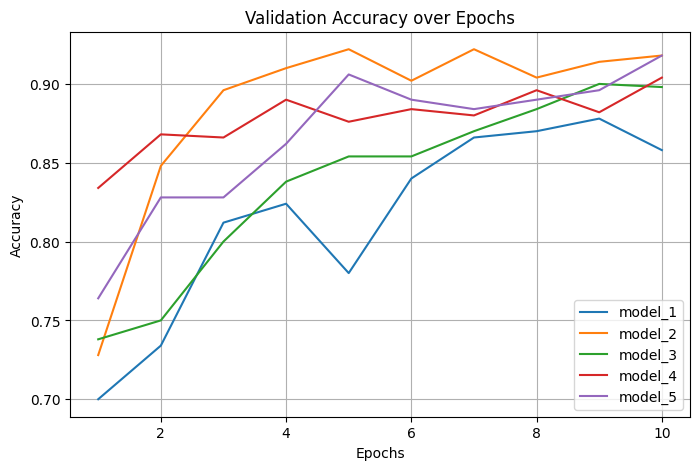

In [15]:
# Plot Validation Accuracy
plt.figure(figsize=(8, 5))
for name, history in models_histories:
    plt.plot(range(1, 11), history["valid_accuracy"], label=name)
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()